In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']

In [3]:
mm = m.copy()

### classifier

In [4]:
mm.run.max()

9

In [5]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [6]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [7]:
# beginning of generation
N = 10
ds = mm[(mm.segment=='generated') & (mm.tokzero<N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

In [8]:
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [9]:
ds

,run,pid,shape0,shape1,shape2,shape3,shape4,shape5,shape6,shape7,...,true_ent2,true_ent3,true_ent4,true_ent5,true_ent6,true_ent7,true_ent8,true_ent9,correct,hallucinated
0,0,9,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,...,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04,False,False
1,0,10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04,False,False
2,0,12,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04,False,False
3,0,14,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,...,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04,False,False
4,0,17,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,...,6.945014e-01,2.445166e-06,1.360828e-04,8.025359e-03,8.336202e-09,5.174461e-07,1.205831e-04,5.824901e-05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,9,1788,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9.010122e-06,1.137201e-05,3.049808e-06,2.346361e-07,1.727000e-08,1.542884e-06,2.139582e-02,1.466352e-05,True,False
6876,9,1789,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,6.993531e-08,1.876450e-06,2.689730e-05,1.488801e-01,1.133345e-08,9.309534e-07,1.654437e-03,1.154494e-01,True,False
6877,9,1790,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7.720306e-04,1.245706e-06,2.812353e-02,3.760191e-06,3.647040e-05,8.510714e-06,1.821284e-07,9.020661e-09,False,False
6878,9,1794,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.436548e-07,4.925757e-07,9.596071e-04,1.008549e-01,7.226087e-08,3.133798e-06,7.783296e-05,2.372521e-06,True,False


In [10]:
ds.correct.value_counts()

correct
True     4977
False    1903
Name: count, dtype: int64

In [11]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [12]:
X.loc[:,X.nunique()!=1].shape

(6880, 30)

In [13]:
X.isnull().sum().sum() == 0

True

In [14]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [15]:
X_res.columns = ['generated_'+col for col in X.columns]

In [16]:
X_res.isnull().sum().sum() == 0

True

In [17]:
X_res

,generated_shape0,generated_shape1,generated_shape2,generated_shape3,generated_shape4,generated_shape5,generated_shape6,generated_shape7,generated_shape8,generated_shape9,...,generated_true_ent0,generated_true_ent1,generated_true_ent2,generated_true_ent3,generated_true_ent4,generated_true_ent5,generated_true_ent6,generated_true_ent7,generated_true_ent8,generated_true_ent9
0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,5.0,1.0,1.0,...,7.224133e-06,0.058420,5.036472e-06,7.166480e-01,1.664804e-08,5.324713e-07,2.034433e-04,1.525819e+00,6.502650e-05,4.334208e-04
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.616158e-06,0.012218,1.506806e-03,2.517824e-01,8.579906e-09,8.837126e-07,1.639340e-04,9.334140e-02,2.433762e-05,5.074464e-04
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,9.756351e-07,0.017998,5.711260e-07,1.362268e-05,1.221164e-05,2.904172e-02,6.464605e-01,2.070488e-08,1.401210e-06,1.227201e-04
3,1.0,1.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,1.0,...,2.472243e-06,0.035839,4.299130e-04,1.115004e+00,9.973774e-07,2.550019e-06,5.443041e-01,3.232657e-08,3.176602e-07,1.276724e-04
7,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,3.738472e-07,0.001135,1.197164e-05,1.271390e-05,9.368955e-02,1.979504e-04,4.482977e-01,1.768928e-06,2.492239e-08,3.399741e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.646218e-07,0.027803,5.486708e-07,3.959493e-07,5.796927e-02,9.068585e-07,2.645776e-05,3.157231e-09,2.654945e-07,7.704456e-05
1194,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.478154e-06,0.000031,5.977021e-03,8.836203e-07,8.251903e-07,9.396472e-07,4.721770e-06,5.488162e-07,2.904450e-08,2.729084e-07
1037,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9.480678e-07,0.002735,5.383671e-05,1.443484e-04,1.331124e-04,7.798612e-06,9.461108e-07,4.218248e-07,6.386966e-09,5.611448e-07
2272,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.317165e-06,0.010464,1.070114e-07,3.282992e-02,2.417590e-06,1.254516e-04,3.751635e-09,4.333836e-07,1.884491e-08,2.602165e-07


### beginning of generation

In [18]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')
pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 6.31 s, sys: 3.39 s, total: 9.71 s
Wall time: 1.57 s


In [19]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.72      0.61      0.66      1903
        True       0.66      0.77      0.71      1903

    accuracy                           0.69      3806
   macro avg       0.69      0.69      0.69      3806
weighted avg       0.69      0.69      0.69      3806



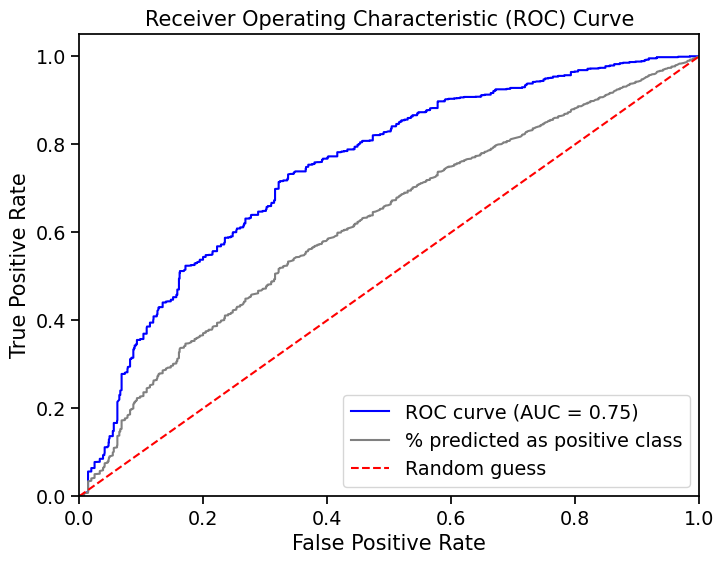

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

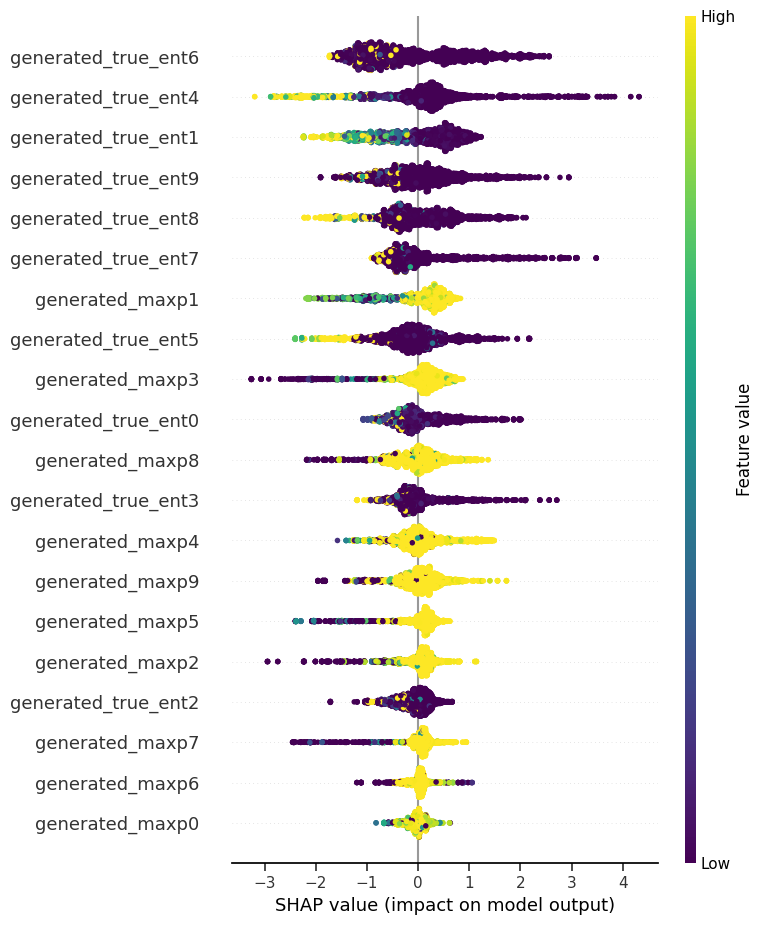

In [22]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

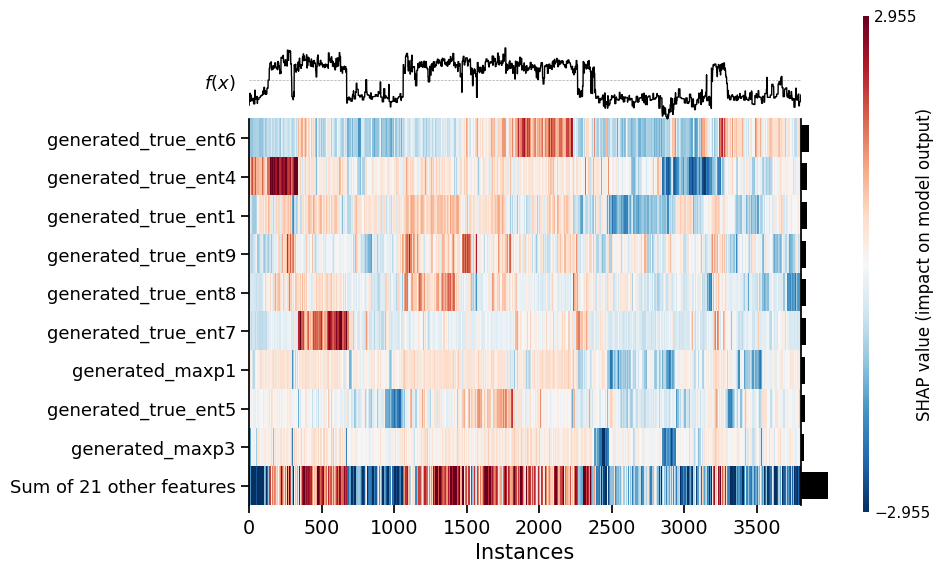

In [23]:
shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [24]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [25]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [26]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.347742
generated_shape       0.008320
generated_true_ent    0.643937
Name: value, dtype: float64

In [27]:
K = 10
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

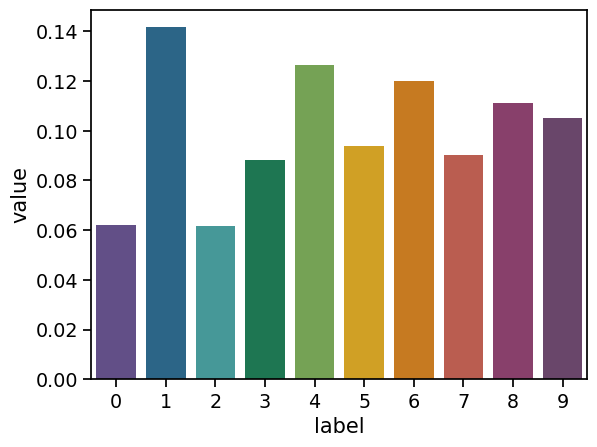

In [28]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

Text(27.44444444444443, 0.5, 'Token index')

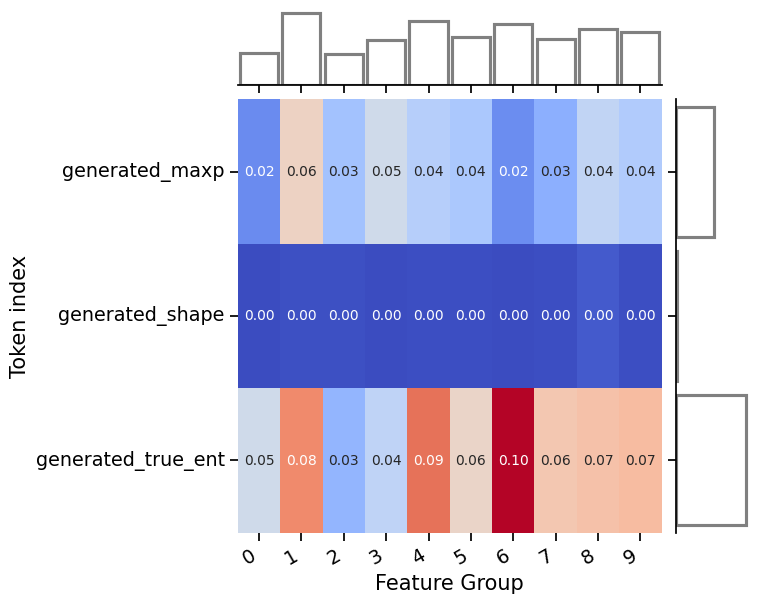

In [29]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of postilla

In [30]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [69]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

In [70]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 35.7 s, sys: 8.44 s, total: 44.1 s
Wall time: 7.15 s


In [71]:
pred = pred_proba_instr.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.63      0.58      0.60      1903
        True       0.61      0.66      0.63      1903

    accuracy                           0.62      3806
   macro avg       0.62      0.62      0.62      3806
weighted avg       0.62      0.62      0.62      3806



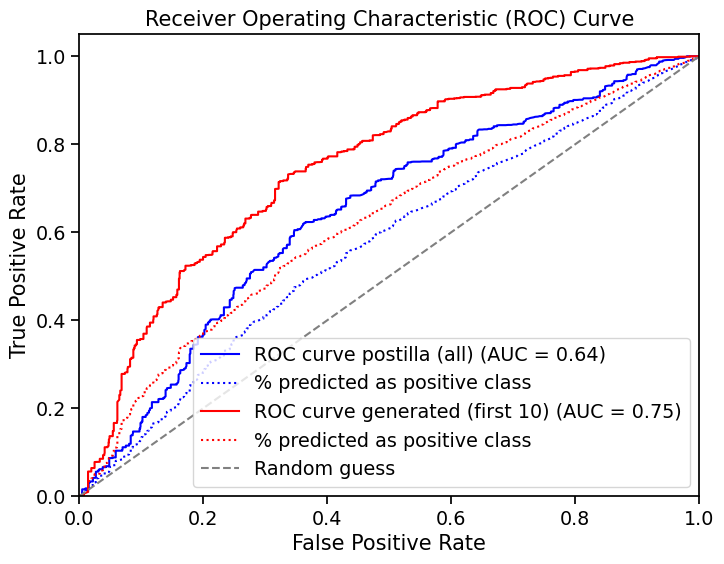

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba_instr[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

 97%|=================== | 3680/3806 [00:11<00:00]       

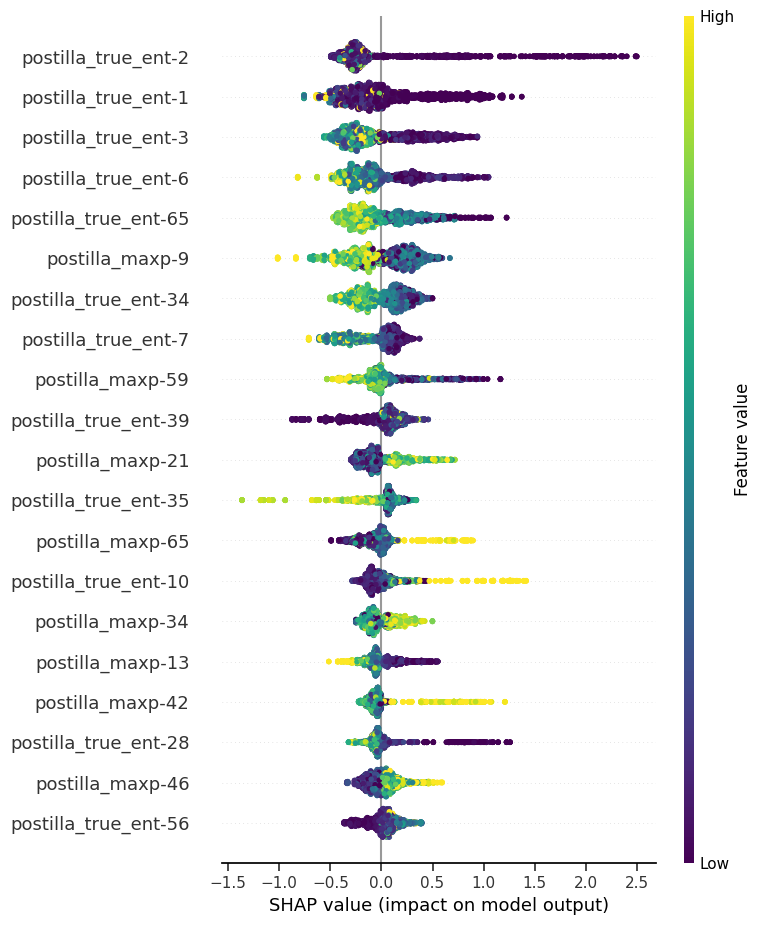

In [35]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [36]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [37]:
K = 10
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [68]:
vals.sort_values('value', ascending=False)[:K].value.sum()

0.7387112323141897

In [38]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.354725
postilla_shape-       0.122639
postilla_true_ent-    0.522636
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



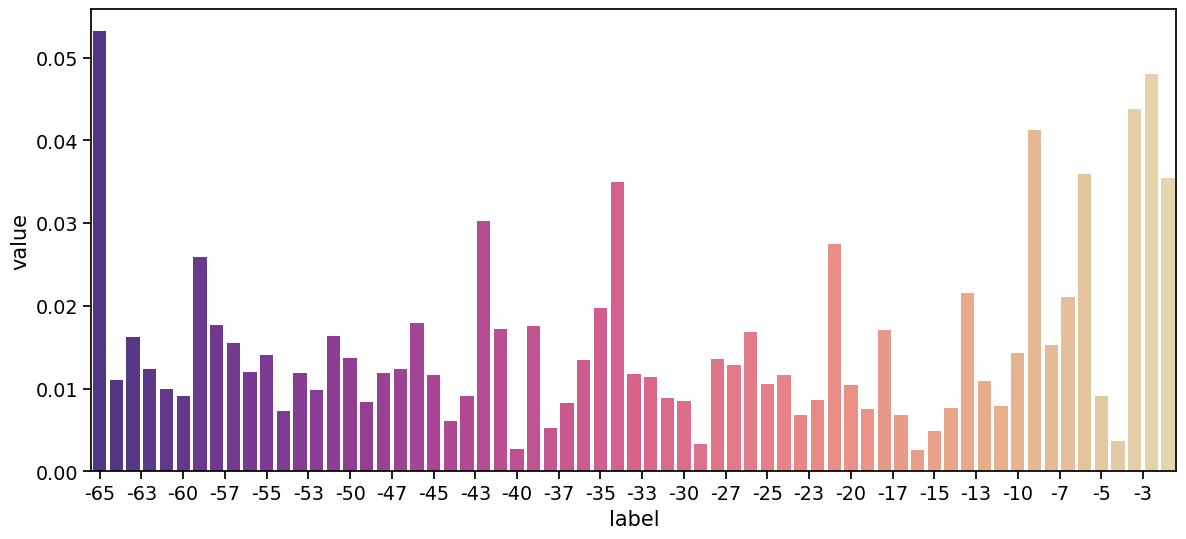

In [39]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

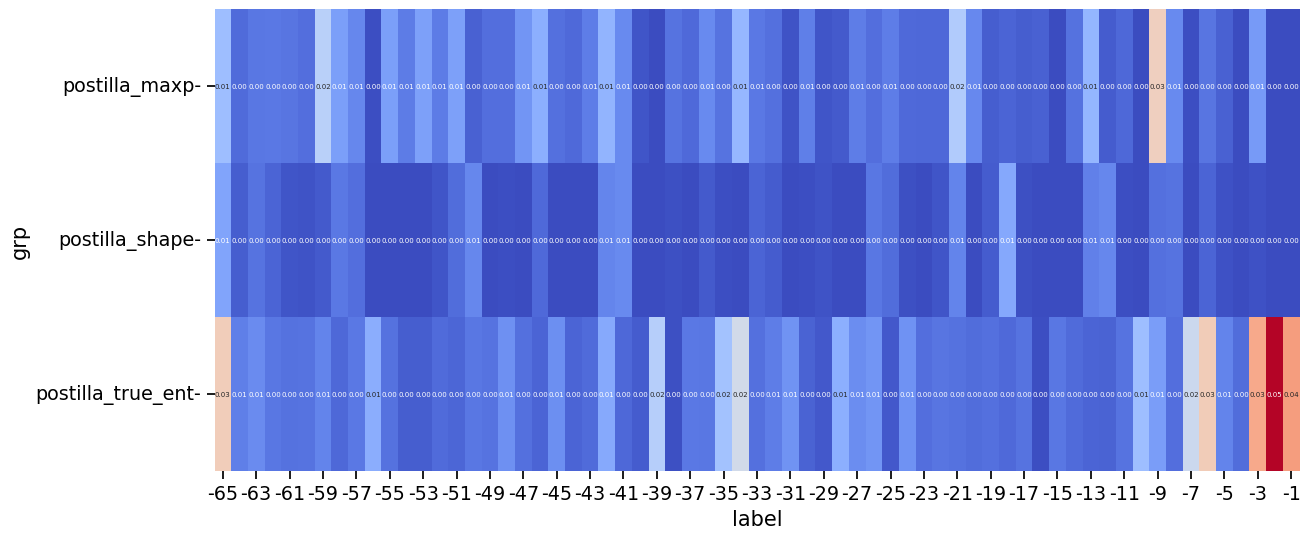

In [40]:
plt.figure(figsize=(14, 6))
_toplot = vals.pivot(index='grp', columns='label', values='value')
ax = plt.gca()
sns.heatmap(_toplot, ax=ax, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":5}, cmap="coolwarm")
plt.show()

### combo

In [41]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692e+00,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560e+00,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911e+00,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726e+00,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033e+00,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137527121,9,1797,5483,generated,1,9.744441e-05,0.999993,5464,5487,generated,5,23,0.999271,5.826087,19,-5
137527127,9,1797,5484,generated,1,8.116461e-05,0.999994,5464,5487,generated,5,23,0.999453,5.869565,20,-4
137527133,9,1797,5485,generated,1,3.123915e-05,0.999998,5464,5487,generated,5,23,0.999636,5.913043,21,-3
137527139,9,1797,5486,generated,1,7.018035e-07,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [47]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=N)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [48]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [49]:
ds.shape, ds1.shape, ds2.shape

((6880, 232), (6880, 37), (6880, 199))

In [51]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELETC TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [52]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 8.17 s, sys: 4.83 s, total: 13 s
Wall time: 1.98 s


In [53]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.73      0.59      0.65      1903
        True       0.65      0.78      0.71      1903

    accuracy                           0.68      3806
   macro avg       0.69      0.68      0.68      3806
weighted avg       0.69      0.68      0.68      3806



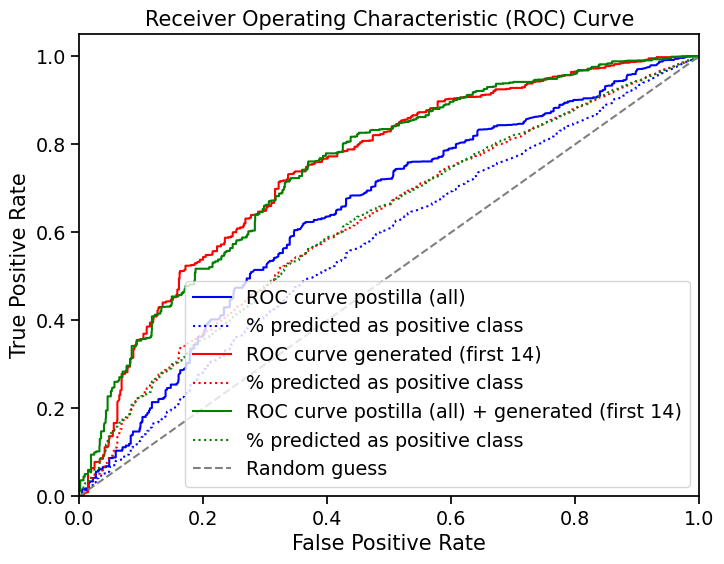

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba_instr[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [55]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [56]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [57]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.131719
generated_true_ent    0.595327
postilla_maxp-        0.063047
postilla_true_ent-    0.209907
Name: value, dtype: float64

In [58]:
vals

,label,value,label_orig,grp
10,6,0.109224,generated_true_ent6,generated_true_ent
11,4,0.096896,generated_true_ent4,generated_true_ent
14,8,0.082960,generated_true_ent8,generated_true_ent
13,9,0.079777,generated_true_ent9,generated_true_ent
18,3,0.072548,generated_maxp3,generated_maxp
15,7,0.069377,generated_true_ent7,generated_true_ent
17,5,0.067224,generated_true_ent5,generated_true_ent
16,1,0.059171,generated_maxp1,generated_maxp
12,1,0.057961,generated_true_ent1,generated_true_ent
5,-9,0.043573,postilla_maxp-9,postilla_maxp-




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

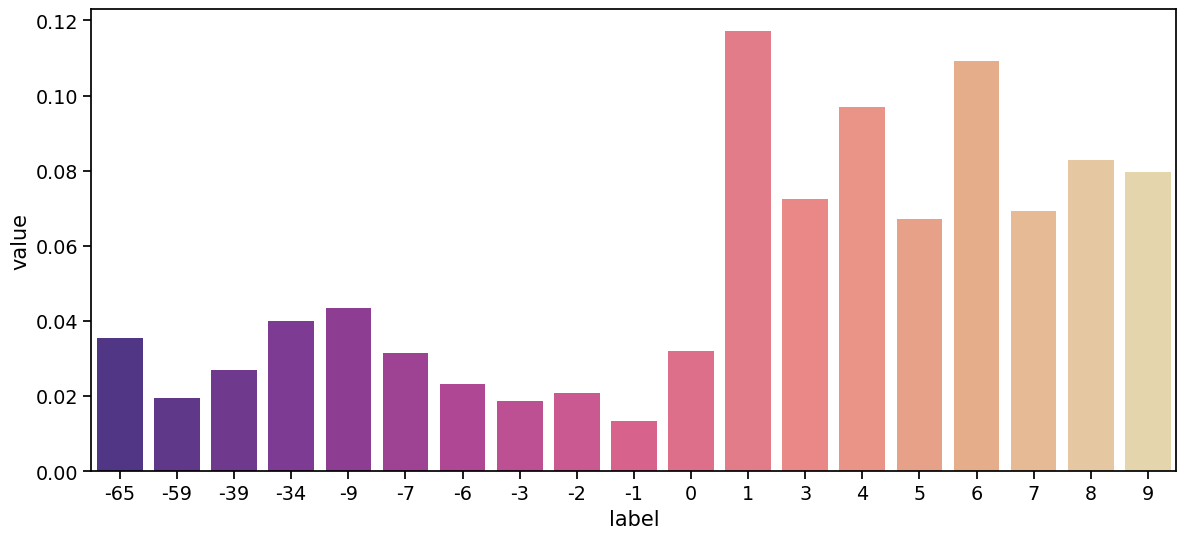

In [59]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

Text(27.44444444444443, 0.5, 'Token index')

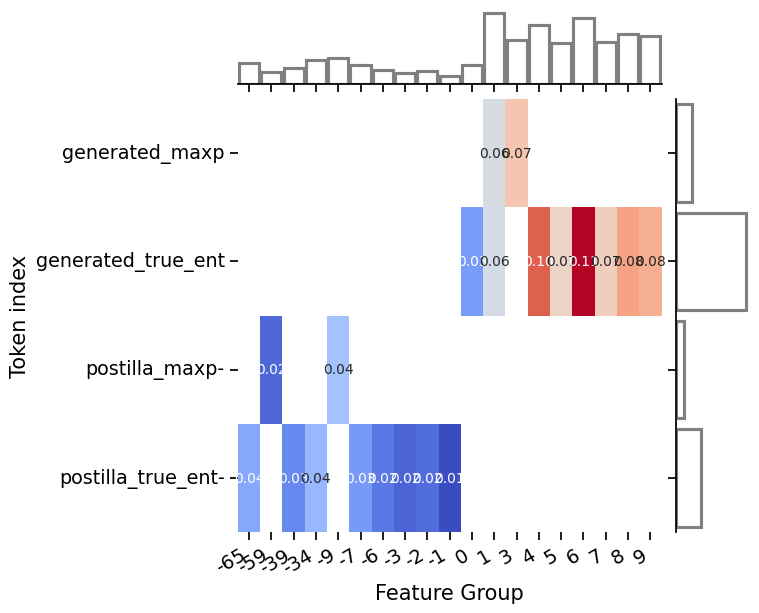

In [60]:
_toplot = vals.pivot(index='grp', columns='label', values='value')

grid = sns.JointGrid()

# Fill the centre with our heatmap
sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt=".2f", annot_kws={"fontsize":10}, cmap="coolwarm")
# Draw total bars, both with width 1, but the Y one with horizontal orientation

sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=0.9, fill=False, color='grey')

sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=0.9, fill=False, color='grey')
# Offset value (just half an unit)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

# Need to use this to set the horizontal_alignment
grid.ax_joint.set_xticklabels(
    grid.ax_joint.get_xticklabels(), 
    rotation=30,    
    ha='right'
)
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Feature Group')
grid.ax_joint.set_ylabel('Token index')

### end of input (no candidates provided yet)

In [77]:
mm.head()

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40,0.000,0.000,0,-41
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40,0.025,0.025,1,-40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40,0.050,0.050,2,-39
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40,0.075,0.075,3,-38
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40,0.100,0.100,4,-37


In [78]:
# end of input (last NN)
NN = 64
ds = mm[(mm.segment=='input') & (mm.tokzero_end>=-NN)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['input_'+col for col in X.columns]

In [80]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_input = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

pred = pred_proba_input.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.53      0.44      0.48      1903
        True       0.52      0.62      0.57      1903

    accuracy                           0.53      3806
   macro avg       0.53      0.53      0.52      3806
weighted avg       0.53      0.53      0.52      3806

CPU times: user 24.6 s, sys: 6.75 s, total: 31.4 s
Wall time: 15.7 s


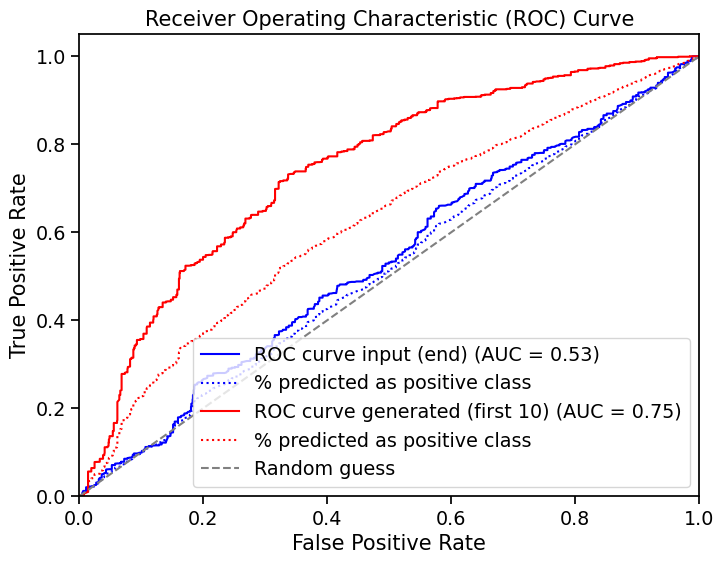

In [81]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_input[:, 1])
true_counts_rel = [(pred_proba_input[:, 1] > thr).sum() / pred_proba_input.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve input (end) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first {N}) (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()